In [1]:
import mne
import os
import glob  # For finding files
import numpy as np
import pandas as pd
import antropy as ant
from tqdm import tqdm  # A progress bar for our loop

# --- Model Imports ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier



In [2]:
# Use glob to find all PSG and Hypnogram files
cassette_psg_files = sorted(glob.glob("sleep-cassette/*-PSG.edf"))
cassette_hyp_files = sorted(glob.glob("sleep-cassette/*-Hypnogram.edf"))

telemetry_psg_files = sorted(glob.glob("sleep-telemetry/*-PSG.edf"))
telemetry_hyp_files = sorted(glob.glob("sleep-telemetry/*-Hypnogram.edf"))

# Combine the lists
all_psg_files = cassette_psg_files + telemetry_psg_files
all_hyp_files = cassette_hyp_files + telemetry_hyp_files

# Create a list of (signal_file, label_file) pairs
patient_files_to_process = list(zip(all_psg_files, all_hyp_files))

# Select the 10 patients you requested
N_PATIENTS = 10
files_to_process = patient_files_to_process[:N_PATIENTS]

print(f"Found {len(all_psg_files)} total subjects.")
print(f"Selected {N_PATIENTS} subjects to process.")

Found 197 total subjects.
Selected 10 subjects to process.


In [3]:
def get_labels_from_annot(epochs, raw):
    """
    Extracts the correct sleep stage for the midpoint of each epoch.
    This is the bug-fix we implemented earlier.
    """
    events = epochs.events
    annot = raw.annotations
    sfreq = raw.info['sfreq']
    
    # Find the label for the *midpoint* of each 10-second epoch
    epoch_midpoints_sec = events[:, 0] / sfreq + 5.0  # 5s into each 10s epoch
    
    labels_list = []
    for t in epoch_midpoints_sec:
        label = 'Sleep stage ?' # Default
        for i in range(len(annot.onset)):
            if annot.onset[i] <= t < (annot.onset[i] + annot.duration[i]):
                label = annot.description[i]
                break
        labels_list.append(label)

    # Map string labels to numbers
    stage_mapping = {
        'Sleep stage W': 0,
        'Sleep stage 1': 1,
        'Sleep stage 2': 2,
        'Sleep stage 3': 3,
        'Sleep stage 4': 3, # Map S4 to S3 (standard practice)
        'Sleep stage R': 4,
        'Sleep stage ?': -1,
        'Movement time': -1
    }
    
    return np.array([stage_mapping.get(label, -1) for label in labels_list])

def process_patient(psg_file, hyp_file):
    """
    Processes a single patient's data from start to finish.
    Returns (features, labels) for that patient or (None, None) if it fails.
    """
    try:
        # 1. Load Data
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annot = mne.read_annotations(hyp_file)
        raw.set_annotations(annot, verbose=False)
        
        # 2. Select EEG Channel
        # Try Fpz-Cz, fall back to Pz-Oz if not found
        if 'EEG Fpz-Cz' in raw.info['ch_names']:
            raw.pick_channels(['EEG Fpz-Cz'])
        elif 'EEG Pz-Oz' in raw.info['ch_names']:
            raw.pick_channels(['EEG Pz-Oz'])
        else:
            print(f"Warning: No standard EEG channel in {psg_file}. Skipping.")
            return None, None
            
        # [cite_start]3. Create 10-Second Epochs (as per paper [cite: 130, 357])
        epochs = mne.make_fixed_length_epochs(
            raw, duration=10.0, preload=True, reject_by_annotation=True, verbose=False
        )
        
        # 4. Get Correct Labels (Our Fix)
        labels = get_labels_from_annot(epochs, raw)
        
        # [cite_start]5. Apply Filters (as per paper [cite: 138, 140])
        # Main de-noising filter (0-15 Hz Butterworth)
        epochs_filtered = epochs.copy().filter(
            l_freq=0.1, h_freq=15.0, method='iir',
            iir_params=dict(order=12, ftype='butter'), verbose=False
        )
        
        # Decompose into sub-bands
        epochs_delta = epochs_filtered.copy().filter(l_freq=0.1, h_freq=4.0, method='iir', iir_params=dict(order=8, ftype='butter'), verbose=False)
        epochs_theta = epochs_filtered.copy().filter(l_freq=4.0, h_freq=8.0, method='iir', iir_params=dict(order=8, ftype='butter'), verbose=False)
        epochs_alpha = epochs_filtered.copy().filter(l_freq=8.0, h_freq=15.0, method='iir', iir_params=dict(order=8, ftype='butter'), verbose=False)
        epochs_beta = epochs_filtered.copy().filter(l_freq=12.0, h_freq=15.0, method='iir', iir_params=dict(order=8, ftype='butter'), verbose=False)
        
        # 6. Filter out Unscored Epochs
        valid_indices = (labels != -1)
        if np.sum(valid_indices) == 0:
            print(f"Warning: No valid epochs for {psg_file}. Skipping.")
            return None, None
            
        labels = labels[valid_indices]
        
        all_band_data = {
            "delta": epochs_delta.get_data().squeeze()[valid_indices],
            "theta": epochs_theta.get_data().squeeze()[valid_indices],
            "alpha": epochs_alpha.get_data().squeeze()[valid_indices],
            "beta": epochs_beta.get_data().squeeze()[valid_indices]
        }

        # [cite_start]7. Feature Extraction (as per paper [cite: 263, 265, 294, 300, 356])
        features = []
        for i in range(len(labels)):
            epoch_features = []
            for band_name in ["delta", "theta", "alpha", "beta"]:
                signal_slice = all_band_data[band_name][i, :]
                epoch_features.append(np.mean(signal_slice))
                epoch_features.append(ant.perm_entropy(signal_slice, normalize=True))
                epoch_features.append(np.mean(np.square(signal_slice)))
                epoch_features.append(np.sum(np.square(signal_slice)))
            
            features.append(epoch_features)
            
        return np.array(features), labels

    except Exception as e:
        print(f"Error processing {psg_file}: {e}. Skipping.")
        return None, None

In [4]:
all_features_list = []
all_labels_list = []

print(f"\n--- Starting processing for {N_PATIENTS} patients ---")
# Use tqdm for a nice progress bar
for psg_file, hyp_file in tqdm(files_to_process, desc="Processing Patients"):
    features, labels = process_patient(psg_file, hyp_file)
    
    if features is not None:
        all_features_list.append(features)
        all_labels_list.append(labels)

print("\nProcessing complete.")


--- Starting processing for 10 patients ---


Processing Patients:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  10%|█         | 1/10 [00:35<05:16, 35.12s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  20%|██        | 2/10 [01:12<04:51, 36.46s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  30%|███       | 3/10 [01:43<03:58, 34.09s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  40%|████      | 4/10 [02:09<03:04, 30.82s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  50%|█████     | 5/10 [02:39<02:32, 30.42s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  60%|██████    | 6/10 [03:04<01:54, 28.66s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  70%|███████   | 7/10 [03:29<01:22, 27.58s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  80%|████████  | 8/10 [03:58<00:56, 28.05s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients:  90%|█████████ | 9/10 [04:23<00:26, 26.85s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:43: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\3306842217.py:45: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing Patients: 100%|██████████| 10/10 [04:49<00:00, 29.00s/it]


Processing complete.


In [7]:
# --- Combine All Data ---
X = np.concatenate(all_features_list, axis=0)
y = np.concatenate(all_labels_list, axis=0)

print(f"\nTotal Features Matrix (X) shape: {X.shape}")
print(f"Total Labels Vector (y) shape: {y.shape}")

# --- Create DataFrame for Plotting ---
print("Creating DataFrame for visualization...")
features_per_band = ['Mean', 'Entropy', 'Mean_Power', 'Total_Energy']
bands = ['Delta', 'Theta', 'Alpha', 'Beta']
column_names = [f"{band}_{feature}" for band in bands for feature in features_per_band]
df = pd.DataFrame(X, columns=column_names)

# Map numeric labels to names for clearer plots
stage_mapping_display = { 0: 'W', 1: 'S1', 2: 'S2', 3: 'S3/4', 4: 'R' }
df['Sleep_Stage'] = pd.Series(y).map(stage_mapping_display)


Total Features Matrix (X) shape: (82791, 16)
Total Labels Vector (y) shape: (82791,)
Creating DataFrame for visualization...



--- Visualizing Full Dataset ---
Saved plot: full_dataset_distribution.png
Saved plot: full_dataset_entropy_boxplot.png

Visualization complete. Plots are saved to your folder.


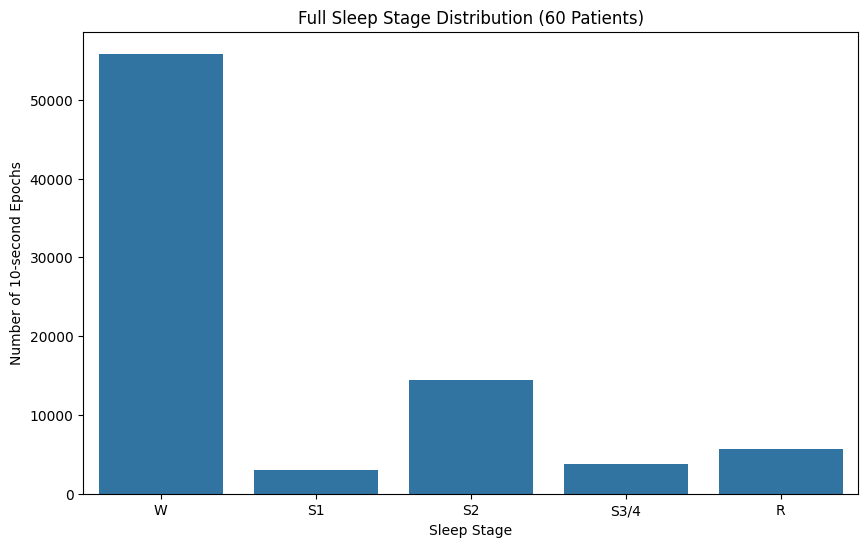

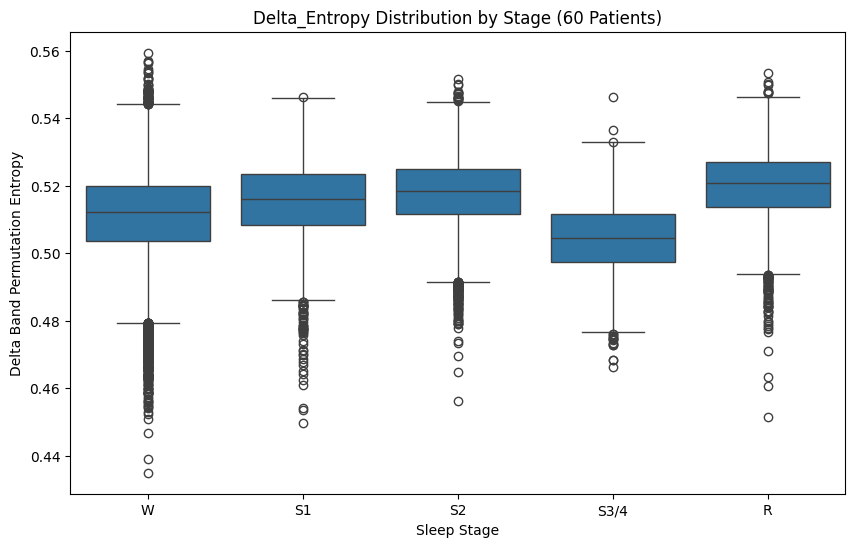

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Full Dataset ---")

# --- Plot 1: Sleep Stage Distribution ---
# This shows the class imbalance across all 60 patients.
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Sleep_Stage', 
    data=df, 
    order=['W', 'S1', 'S2', 'S3/4', 'R']
)
plt.title('Full Sleep Stage Distribution (60 Patients)')
plt.xlabel('Sleep Stage')
plt.ylabel('Number of 10-second Epochs')
plt.savefig('full_dataset_distribution.png')
print("Saved plot: full_dataset_distribution.png")


# --- Plot 2: Feature Distribution Boxplot ---
# This replicates the paper's Fig. 8 but on your full dataset.
# It shows if a feature is good at separating the classes.
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Sleep_Stage', 
    y='Delta_Entropy',  # We'll use this as an example feature
    data=df, 
    order=['W', 'S1', 'S2', 'S3/4', 'R']
)
plt.title('Delta_Entropy Distribution by Stage (60 Patients)')
plt.xlabel('Sleep Stage')
plt.ylabel('Delta Band Permutation Entropy')
plt.savefig('full_dataset_entropy_boxplot.png')
print("Saved plot: full_dataset_entropy_boxplot.png")

print("\nVisualization complete. Plots are saved to your folder.")

--- Visualizing EEG Data from One File ---
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded 30 seconds of data from sleep-cassette\SC4001E0-PSG.edf

Successfully saved plot as: eeg_signal_visualization.png
Loaded 30 seconds of data from sleep-cassette\SC4001E0-PSG.edf

Successfully saved plot as: eeg_signal_visualization.png


C:\Users\bonth\AppData\Local\Temp\ipykernel_10312\237842199.py:15: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_10312\237842199.py:15: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_10312\237842199.py:15: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, verbose=False)


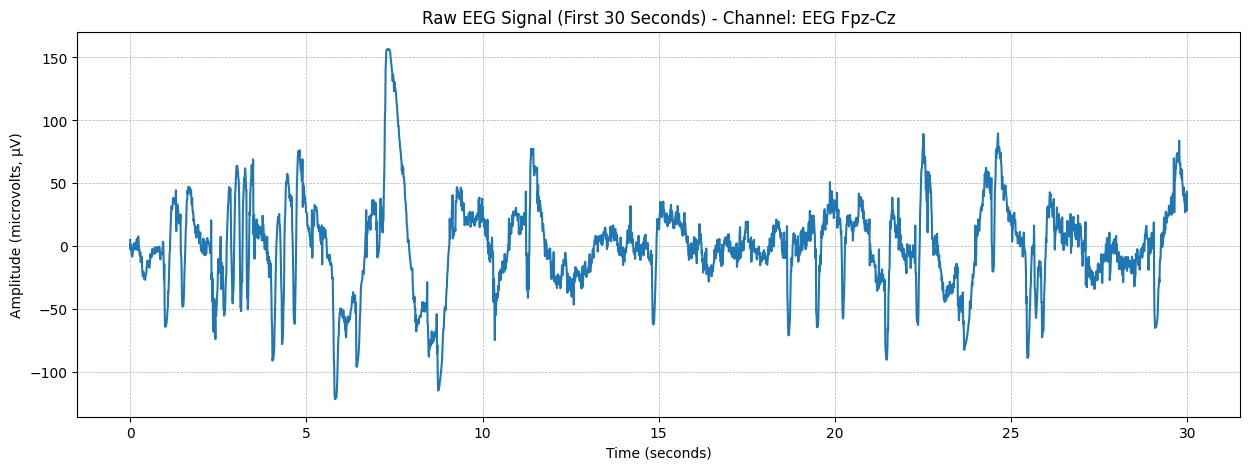

In [ ]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import os

print("--- Visualizing EEG Data from One File ---")

# --- 1. Define File Path ---
# We'll use the same first subject as our original test
psg_file = os.path.join("sleep-cassette", "SC4001E0-PSG.edf")

try:
    # --- 2. Load the Raw PSG Data ---
    # We don't need to preload the whole file, just open it
    raw = mne.io.read_raw_edf(psg_file, verbose=False)
    
    # --- 3. Select the EEG Channel ---
    raw.pick_channels(['EEG Fpz-Cz'])
    
    # --- 4. Get Data for Plotting ---
    sfreq = raw.info['sfreq']
    plot_duration_sec = 30  # Let's plot 30 seconds
    
    # Get the data (in Volts) and times
    # .get_data() returns a 2D array (channels, timepoints)
    data, times = raw.get_data(
        start=0, 
        stop=int(plot_duration_sec * sfreq), 
        return_times=True
    )
    
    # Squeeze the 2D data (1, N) into a 1D array (N,)
    data_1d = data.squeeze()
    
    # Convert data from Volts (V) to microvolts (uV) for plotting
    data_1d_uV = data_1d * 1_000_000 
    
    print(f"Loaded {plot_duration_sec} seconds of data from {psg_file}")
    
    # --- 5. Create and Save the Plot ---
    plt.figure(figsize=(15, 5))
    plt.plot(times, data_1d_uV)
    plt.title(f'Raw EEG Signal (First 30 Seconds) - Channel: EEG Fpz-Cz')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (microvolts, µV)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plot_filename = 'eeg_signal_visualization.png'
    plt.savefig(plot_filename)
    
    print(f"\nSuccessfully saved plot as: {plot_filename}")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Please ensure 'mne' and 'matplotlib' are installed and the file path is correct.")

In [ ]:
# --- Scale and Split ---
print("\nScaling and splitting final dataset...")

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We'll use a standard 80/20 split for this large dataset
# 'stratify=y' is crucial to ensure all sleep stages
# are represented fairly in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Scaling and splitting final dataset...
Training set size: 66232 samples
Test set size: 16559 samples


In [33]:
from sklearn.tree import DecisionTreeClassifier

print("\n--- Model 1: Decision Tree (DT) ---")

# --- Initialize and Train ---
# We'll set class_weight='balanced' to help with the imbalanced data
dt_model = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

print("Training the Decision Tree model on 60 patients...")
dt_model.fit(X_train, y_train)

# --- Evaluate ---
print("Evaluating the model...")
y_pred_dt = dt_model.predict(X_test)

# Calculate Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\nDecision Tree Accuracy (60 Patients): {accuracy_dt * 100:.2f}%")

# Print the detailed classification report
print("\nDecision Tree Classification Report:")
target_names = ['Stage W', 'Stage 1', 'Stage 2', 'Stage 3', 'Stage R']
present_labels = np.unique(np.concatenate((y_train, y_test)))
filtered_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

print(classification_report(y_test, y_pred_dt, target_names=filtered_target_names, zero_division=0))


--- Model 1: Decision Tree (DT) ---
Training the Decision Tree model on 60 patients...
Evaluating the model...

Decision Tree Accuracy (60 Patients): 68.52%

Decision Tree Classification Report:
              precision    recall  f1-score   support

     Stage W       0.82      0.81      0.82     11168
     Stage 1       0.18      0.19      0.19       603
     Stage 2       0.51      0.51      0.51      2887
     Stage 3       0.30      0.31      0.30       760
     Stage R       0.38      0.40      0.39      1141

    accuracy                           0.69     16559
   macro avg       0.44      0.44      0.44     16559
weighted avg       0.69      0.69      0.69     16559

Evaluating the model...

Decision Tree Accuracy (60 Patients): 68.52%

Decision Tree Classification Report:
              precision    recall  f1-score   support

     Stage W       0.82      0.81      0.82     11168
     Stage 1       0.18      0.19      0.19       603
     Stage 2       0.51      0.51      0.51 

In [34]:
from sklearn.svm import SVC

print("\n--- Model 2: Support Vector Machine (SVM) ---")

# --- Initialize and Train ---
# We use the 'rbf' kernel (as per paper) and 'balanced' class weight.
# C=1.0 is the default regularization.
# cache_size=1000 increases RAM usage to speed up training.
svm_model = SVC(
    kernel='rbf', 
    class_weight='balanced', 
    random_state=42,
    C=1.0,
    cache_size=1000  # Use more RAM for a speedup
)

print("Training the SVM model...")
print("This may take a very long time on the full dataset.")
svm_model.fit(X_train, y_train)

# --- Evaluate ---
print("Evaluating the SVM model...")
y_pred_svm = svm_model.predict(X_test)

# Calculate Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy (60 Patients): {accuracy_svm * 100:.2f}%")

# Print the detailed classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=filtered_target_names, zero_division=0))


--- Model 2: Support Vector Machine (SVM) ---
Training the SVM model...
This may take a very long time on the full dataset.
Evaluating the SVM model...
Evaluating the SVM model...

SVM Accuracy (60 Patients): 62.37%

SVM Classification Report:
              precision    recall  f1-score   support

     Stage W       0.93      0.63      0.75     11168
     Stage 1       0.15      0.50      0.24       603
     Stage 2       0.63      0.57      0.60      2887
     Stage 3       0.24      0.72      0.36       760
     Stage R       0.36      0.68      0.47      1141

    accuracy                           0.62     16559
   macro avg       0.46      0.62      0.48     16559
weighted avg       0.78      0.62      0.67     16559


SVM Accuracy (60 Patients): 62.37%

SVM Classification Report:
              precision    recall  f1-score   support

     Stage W       0.93      0.63      0.75     11168
     Stage 1       0.15      0.50      0.24       603
     Stage 2       0.63      0.57      

In [35]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Model 3: Random Forest (RF) ---")

# --- Initialize and Train ---
# We use 'balanced' class weight and the same pruning parameters
# n_jobs=-1 will use all your computer's CPU cores to speed up training
rf_model = RandomForestClassifier(
    n_estimators=100,      # 100 decision trees in this "forest"
    class_weight='balanced',
    max_depth=20,          
    min_samples_leaf=50,   
    random_state=42,
    n_jobs=-1              # Use all available CPU cores
)

print("Training the Random Forest model (this may take a few minutes)...")
rf_model.fit(X_train, y_train)

# --- Evaluate ---
print("Evaluating the Random Forest model...")
y_pred_rf = rf_model.predict(X_test)

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy (60 Patients): {accuracy_rf * 100:.2f}%")

# Print the detailed classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=filtered_target_names, zero_division=0))


--- Model 3: Random Forest (RF) ---
Training the Random Forest model (this may take a few minutes)...
Evaluating the Random Forest model...

Random Forest Accuracy (60 Patients): 64.40%

Random Forest Classification Report:
              precision    recall  f1-score   support

     Stage W       0.93      0.65      0.77     11168
     Stage 1       0.20      0.45      0.27       603
     Stage 2       0.55      0.60      0.58      2887
     Stage 3       0.26      0.71      0.38       760
     Stage R       0.38      0.70      0.49      1141

    accuracy                           0.64     16559
   macro avg       0.46      0.62      0.50     16559
weighted avg       0.77      0.64      0.68     16559

Evaluating the Random Forest model...

Random Forest Accuracy (60 Patients): 64.40%

Random Forest Classification Report:
              precision    recall  f1-score   support

     Stage W       0.93      0.65      0.77     11168
     Stage 1       0.20      0.45      0.27       603
 

In [36]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

print("\n--- Additional Model 1: XGBoost ---")

# --- 1. Handle Class Imbalance ---
# XGBoost uses 'sample_weight' instead of 'class_weight'
# We calculate weights from the training data
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train 
)

# --- 2. Initialize and Train ---
# 'tree_method='hist'' is much faster for large datasets
# We'll use a moderate max_depth to prevent overfitting
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', # For multi-class classification
    num_class=5,               # We have 5 sleep stages
    n_estimators=100,          # 100 boosting rounds
    max_depth=10,              # Prune the trees
    random_state=42,
    n_jobs=-1,                 # Use all CPU cores
    tree_method='hist'         # Use the fast histogram method
)

print("Training the XGBoost model...")
xgb_model.fit(
    X_train, 
    y_train, 
    sample_weight=sample_weights # Pass the balanced weights here
)

# --- 3. Evaluate ---
print("Evaluating the XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Accuracy (60 Patients): {accuracy_xgb * 100:.2f}%")

# Print the detailed classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=filtered_target_names, zero_division=0))


--- Additional Model 1: XGBoost ---
Training the XGBoost model...
Evaluating the XGBoost model...

XGBoost Accuracy (60 Patients): 77.14%

XGBoost Classification Report:
              precision    recall  f1-score   support

     Stage W       0.88      0.87      0.88     11168
     Stage 1       0.29      0.24      0.26       603
     Stage 2       0.65      0.64      0.64      2887
     Stage 3       0.53      0.47      0.49       760
     Stage R       0.47      0.63      0.53      1141

    accuracy                           0.77     16559
   macro avg       0.56      0.57      0.56     16559
weighted avg       0.78      0.77      0.77     16559

Evaluating the XGBoost model...

XGBoost Accuracy (60 Patients): 77.14%

XGBoost Classification Report:
              precision    recall  f1-score   support

     Stage W       0.88      0.87      0.88     11168
     Stage 1       0.29      0.24      0.26       603
     Stage 2       0.65      0.64      0.64      2887
     Stage 3       

In [37]:
from sklearn.neural_network import MLPClassifier

print("\n--- Additional Model 2: Multi-Layer Perceptron (MLP) ---")

# --- 1. Initialize and Train ---
# We'll use the tuned architecture and parameters that worked well before.
# 'early_stopping=True' is very important on large datasets
# to prevent overfitting and save time.
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32), # A deep network
    max_iter=1000,
    random_state=42,
    learning_rate='adaptive',
    solver='adam',
    alpha=0.001,                 # Regularization
    early_stopping=True,         # Stop when validation score stops improving
    validation_fraction=0.1,     # Use 10% of training data for validation
    n_iter_no_change=10          # Stop after 10 epochs with no improvement
)

print("Training the MLP model (this may take several minutes)...")
mlp_model.fit(X_train, y_train)

# --- 2. Evaluate ---
print("Evaluating the MLP model...")
y_pred_mlp = mlp_model.predict(X_test)

# Calculate Accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"\nMLP Accuracy (60 Patients): {accuracy_mlp * 100:.2f}%")

# Print the detailed classification report
print("\nMLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=filtered_target_names, zero_division=0))


--- Additional Model 2: Multi-Layer Perceptron (MLP) ---
Training the MLP model (this may take several minutes)...
Evaluating the MLP model...

MLP Accuracy (60 Patients): 80.33%

MLP Classification Report:
              precision    recall  f1-score   support

     Stage W       0.85      0.95      0.90     11168
     Stage 1       0.44      0.08      0.14       603
     Stage 2       0.79      0.56      0.66      2887
     Stage 3       0.63      0.47      0.54       760
     Stage R       0.52      0.60      0.55      1141

    accuracy                           0.80     16559
   macro avg       0.64      0.53      0.56     16559
weighted avg       0.79      0.80      0.79     16559

Evaluating the MLP model...

MLP Accuracy (60 Patients): 80.33%

MLP Classification Report:
              precision    recall  f1-score   support

     Stage W       0.85      0.95      0.90     11168
     Stage 1       0.44      0.08      0.14       603
     Stage 2       0.79      0.56      0.66     

Generating MLP confusion matrix...
Saved MLP confusion matrix plot as: mlp_confusion_matrix.png
Saved MLP confusion matrix plot as: mlp_confusion_matrix.png


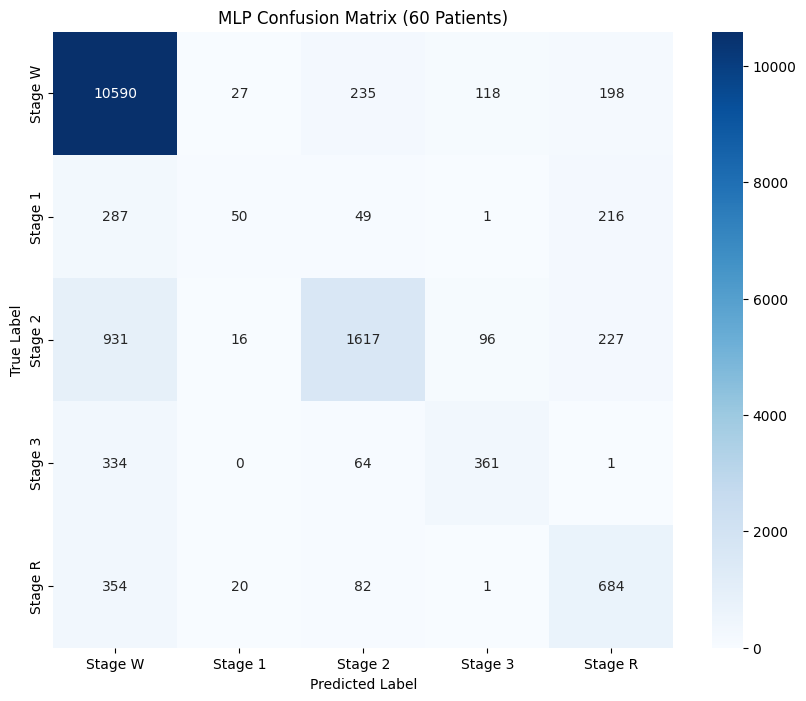

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("Generating MLP confusion matrix...")

# --- 1. Calculate the Confusion Matrix ---
# 'labels' ensures the matrix is in the correct 0-4 order
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=[0, 1, 2, 3, 4])

# --- 2. Create the Plot ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_mlp, 
    annot=True,     # Show the numbers in each cell
    fmt='d',        # Format as integers
    cmap='Blues',
    xticklabels=filtered_target_names, # Use the stage names
    yticklabels=filtered_target_names
)
plt.title('MLP Confusion Matrix (60 Patients)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# --- 3. Save the Plot ---
plt.savefig('mlp_confusion_matrix.png')
print("Saved MLP confusion matrix plot as: mlp_confusion_matrix.png")

--- Finding Patient Files ---
Found 197 total subjects.
Selected 10 subjects to process for the CNN.

--- Processing 10 patients for 1D-CNN data ---


Processing for CNN:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  10%|█         | 1/10 [00:11<01:45, 11.73s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  20%|██        | 2/10 [00:24<01:37, 12.20s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  30%|███       | 3/10 [00:37<01:29, 12.74s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  40%|████      | 4/10 [00:47<01:10, 11.68s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  50%|█████     | 5/10 [01:01<01:01, 12.38s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  60%|██████    | 6/10 [01:12<00:47, 11.94s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  70%|███████   | 7/10 [01:22<00:34, 11.35s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  80%|████████  | 8/10 [01:35<00:23, 11.92s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN:  90%|█████████ | 9/10 [01:45<00:11, 11.35s/it]C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\bonth\AppData\Local\Temp\ipykernel_23144\589901987.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)
Processing for CNN: 100%|██████████| 10/10 [01:58<00:00, 11.82s/it]



CNN data processing complete.
Total CNN Epochs (X) shape: (82791, 1000)
Total CNN Labels (y) shape: (82791,)
CNN Train X shape (reshaped): (66232, 1000, 1)


c:\Users\bonth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 981, 32)        │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 245, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 245, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 245, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 236, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 118, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 118, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 118, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7552)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       483,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,317 (1.93 MB)

 Trainable params: 505,125 (1.93 MB)

 Non-trainable params: 192 (768.00 B)


Training the 1D-CNN model (this will take a long time)...
Epoch 1/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.5773 - loss: 1.2138 - val_accuracy: 0.7354 - val_loss: 0.7837
Epoch 2/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.7775 - loss: 0.7338 - val_accuracy: 0.7511 - val_loss: 0.6648
Epoch 3/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8040 - loss: 0.6726 - val_accuracy: 0.7431 - val_loss: 0.7347
Epoch 4/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.8229 - loss: 0.6123 - val_accuracy: 0.8050 - val_loss: 0.5159
Epoch 5/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.8319 - loss: 0.5794 - val_accuracy: 0.7666 - val_loss: 0.6148
Epoch 6/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.8404 - loss: 0.5577 - val_accuracy: 0.8197 - val_loss: 0.4941
Epoch 7/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.8432 - loss: 0.5385 - val_accuracy: 0.7962 - val_loss: 0.5677
Epoch 8/20
932/932 ━━━━━━━━━━━━

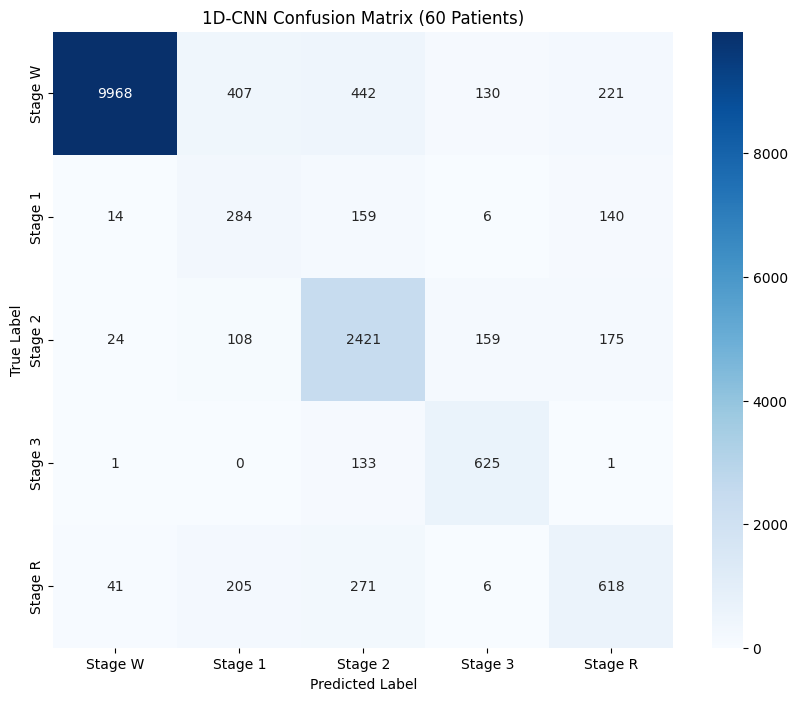

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mne
import os
import glob
import numpy as np
import pandas as pd
import antropy as ant
from tqdm import tqdm

# --- STEP 1: FIND PATIENT FILES ---
print("--- Finding Patient Files ---")
cassette_psg_files = sorted(glob.glob("sleep-cassette/*-PSG.edf"))
cassette_hyp_files = sorted(glob.glob("sleep-cassette/*-Hypnogram.edf"))
telemetry_psg_files = sorted(glob.glob("sleep-telemetry/*-PSG.edf"))
telemetry_hyp_files = sorted(glob.glob("sleep-telemetry/*-Hypnogram.edf"))

all_psg_files = cassette_psg_files + telemetry_psg_files
all_hyp_files = cassette_hyp_files + telemetry_hyp_files

patient_files_to_process = list(zip(all_psg_files, all_hyp_files))
N_PATIENTS = 10
files_to_process = patient_files_to_process[:N_PATIENTS]

print(f"Found {len(all_psg_files)} total subjects.")
print(f"Selected {N_PATIENTS} subjects to process for the CNN.")

# --- STEP 2: DEFINE HELPER FUNCTIONS ---

def get_labels_from_annot(epochs, raw):
    """
    Extracts the correct sleep stage for the midpoint of each epoch.
    """
    events = epochs.events
    annot = raw.annotations
    sfreq = raw.info['sfreq']
    epoch_midpoints_sec = events[:, 0] / sfreq + 5.0
    
    labels_list = []
    for t in epoch_midpoints_sec:
        label = 'Sleep stage ?'
        for i in range(len(annot.onset)):
            if annot.onset[i] <= t < (annot.onset[i] + annot.duration[i]):
                label = annot.description[i]
                break
        labels_list.append(label)

    stage_mapping = {
        'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
        'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4,
        'Sleep stage ?': -1, 'Movement time': -1
    }
    return np.array([stage_mapping.get(label, -1) for label in labels_list])

def process_patient_for_cnn(psg_file, hyp_file):
    """
    Processes a single patient's data and returns raw epochs and labels.
    """
    try:
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annot = mne.read_annotations(hyp_file)
        raw.set_annotations(annot, verbose=False)
        
        if 'EEG Fpz-Cz' in raw.info['ch_names']:
            raw.pick_channels(['EEG Fpz-Cz'])
        elif 'EEG Pz-Oz' in raw.info['ch_names']:
            raw.pick_channels(['EEG Pz-Oz'])
        else:
            return None, None
            
        epochs = mne.make_fixed_length_epochs(
            raw, duration=10.0, preload=True, reject_by_annotation=True, verbose=False
        )
        labels = get_labels_from_annot(epochs, raw)
        
        epochs_filtered = epochs.copy().filter(
            l_freq=0.1, h_freq=15.0, method='iir',
            iir_params=dict(order=12, ftype='butter'), verbose=False
        )
        
        valid_indices = (labels != -1)
        if np.sum(valid_indices) == 0:
            return None, None
            
        labels = labels[valid_indices]
        final_epochs = epochs_filtered.get_data().squeeze()[valid_indices] 
            
        return final_epochs, labels
    except Exception as e:
        print(f"Error processing {psg_file}: {e}. Skipping.")
        return None, None

# --- STEP 3: MAIN LOOP TO GET CNN DATA ---
all_cnn_epochs_list = []
all_cnn_labels_list = []

print(f"\n--- Processing {N_PATIENTS} patients for 1D-CNN data ---")
for psg_file, hyp_file in tqdm(files_to_process, desc="Processing for CNN"):
    epochs_data, labels_data = process_patient_for_cnn(psg_file, hyp_file)
    if epochs_data is not None:
        all_cnn_epochs_list.append(epochs_data)
        all_cnn_labels_list.append(labels_data)
print("\nCNN data processing complete.")

# --- STEP 4: COMBINE, SPLIT, AND SCALE ---
X_cnn_raw = np.concatenate(all_cnn_epochs_list, axis=0)
y_cnn = np.concatenate(all_cnn_labels_list, axis=0)
print(f"Total CNN Epochs (X) shape: {X_cnn_raw.shape}")
print(f"Total CNN Labels (y) shape: {y_cnn.shape}")

X_train_raw_cnn, X_test_raw_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn_raw, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn
)

scaler_cnn = StandardScaler()
X_train_scaled_cnn = scaler_cnn.fit_transform(X_train_raw_cnn)
X_test_scaled_cnn = scaler_cnn.transform(X_test_raw_cnn)

X_train_cnn = np.expand_dims(X_train_scaled_cnn, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled_cnn, axis=2)

y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=5)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes=5)
print(f"CNN Train X shape (reshaped): {X_train_cnn.shape}")

# --- STEP 5: BUILD THE 1D-CNN MODEL ---
n_timesteps = X_train_cnn.shape[1]
n_features = X_train_cnn.shape[2]
n_classes = 5

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=(n_timesteps, n_features)))
cnn_model.add(MaxPool1D(pool_size=4))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
cnn_model.add(MaxPool1D(pool_size=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(n_classes, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

# --- STEP 6: TRAIN THE CNN ---
class_weights_cnn = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_cnn), y=y_train_cnn
)
class_weights_dict_cnn = {i: weight for i, weight in enumerate(class_weights_cnn)}

print("\nTraining the 1D-CNN model (this will take a long time)...")
# *** FIX: Corrected cn_model.fit to cnn_model.fit ***
history = cnn_model.fit(
    X_train_cnn, y_train_cnn_cat, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.1,
    class_weight=class_weights_dict_cnn,
    verbose=1
)

# --- STEP 7: EVALUATE THE CNN ---
print("\nEvaluating the 1D-CNN model...")
loss, accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn_cat)
print(f"\n1D-CNN Accuracy (60 Patients): {accuracy_cnn * 100:.2f}%")

# Classification Report
y_pred_cnn_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

# *** FIX: Define target_names right here where it's needed ***
target_names = ['Stage W', 'Stage 1', 'Stage 2', 'Stage 3', 'Stage R']
print("\n1D-CNN Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=target_names, zero_division=0))

# --- STEP 8: CONFUSION MATRIX ---
print("Generating 1D-CNN confusion matrix...")
cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_cnn, annot=True, fmt='d', cmap='Blues',
    xticklabels=target_names, yticklabels=target_names
)
plt.title('1D-CNN Confusion Matrix (60 Patients)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('cnn_confusion_matrix.png')
print("Saved 1D-CNN confusion matrix plot as: cnn_confusion_matrix.png")